In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from generate_data import *
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

#####################
# Set parameters
#####################


In [52]:
base = ['vnf label', 'vnf min cpu', 'vnf min mem', 'vnf min sto', 'vnf vm cpu',
       'vnf vm mem', 'vnf vm sto', 'vnf pm id', 'vnf cpu usage',
       'vnf mem usage', 'vnf sto usage', 'vnf before', 'vnf after',
       'vnf label.1', 'vnf min cpu.1', 'vnf min mem.1', 'vnf min sto.1',
       'vnf vm cpu.1', 'vnf vm mem.1', 'vnf vm sto.1', 'vnf pm id.1',
       'vnf cpu usage.1', 'vnf mem usage.1', 'vnf sto usage.1', 'vnf before.1',
       'vnf after.1', 'sla', 'fg id', 'flow traffic', 'flow latency',
       'flow bnd usage', 'flow packet loss', 'min cpu affinity',
       'min mem affinity', 'min sto affinity', 'conflicts affinity',
       'real_affinity', 'static_affinity', 'predicted_affinity',
       'prediction_time', 'TF', 'MTT', 'MTT_upper', 'MTT_lower', 'MTTF_R',
       'MTTF_EM', 'MTTF_C', 'MTTF_TDDB', 'MTTF_SM', 'MTTFF_TC', 'A', 'AEM',
       'AC', 'ATDDB', 'ASM', 'ATC', 'TAA', 'QRED', 'QR', 'PUE', 'DCie', 'cost',
       'TIMESTAMP', 'EXTERNAL_TEMP', 'ROOM_TEMP', 'MTTF_IC', 'A_TC', 'Q_DIT',
       'TPF', 'AIRFLOW', 'TAAF', 'DeltaT_de', 'QD']
       
       
#Select your global variable among one of above, and place it after base below


base = 'vnf cpu usage'


### Reading input dataset

In [53]:
fgs = pd.read_csv('../fgs.csv')

In [54]:
fgs.head()

,,,,4963594775,1,2
proxy.9.5698,traffic counter.7.5664,0.971442,82.243099,1.794354,9.341767,100.0
5402488769,5,1.000000,NaN,NaN,NaN,NaN
traffic counter.7.7413,proxy.9.11244,4.060322,119.086081,16.548350,8.474562,150.0
proxy.9.11244,proxy.9.2362,0.268318,23.865256,11.573841,9.248256,150.0
proxy.9.2362,traffic counter.7.9524,2.961259,80.083566,18.280812,4.783467,150.0


In [55]:
vns = pd.read_csv('../vnfs.csv', header=None)

In [56]:
#Just separating our input dataset, for better understanding of dataset
vnf_id = np.array(vns[vns.columns[0]])
vnf_type = np.array(vns[vns.columns[1]])
vnf_scheduling = np.array(vns[vns.columns[2]])
vnf_pm = np.array(vns[vns.columns[3]])
vnf_fg = np.array(vns[vns.columns[4]])
flavor_data = np.array(vns[vns.columns[5:8]])
vm_data = np.array(vns[vns.columns[8:11]])
usage_data = np.array(vns[vns.columns[11:15]])

In [57]:
vm_data.shape

(12322, 3)

In [58]:
output = pd.read_csv('../new_results_out.csv', sep =';')# Reading target dataset
output.drop('Unnamed: 0',axis = 1, inplace=True)

In [59]:
output.head()

,vnf label,vnf min cpu,vnf min mem,vnf min sto,vnf vm cpu,vnf vm mem,vnf vm sto,vnf pm id,vnf cpu usage,vnf mem usage,...,EXTERNAL_TEMP,ROOM_TEMP,MTTF_IC,A_TC,Q_DIT,TPF,AIRFLOW,TAAF,DeltaT_de,QD
0,dpi.2.136144,0.035914,0.226393,0.001757,0.06250,0.12720,0.001930,257345416,71.88000,1.75780,...,15,23,2435.249666,0.996726,1.839678,14.999377,0.131858,0.872117,6.132259,6.132259
1,traffic counter.7.40368,0.063818,0.017674,0.000223,0.06189,0.03821,0.000386,3488796635,3.51600,6.34800,...,15,24,49.077683,0.859840,1.801941,14.999402,0.142946,0.768427,6.006469,6.006469
2,proxy.9.13456,0.018672,0.020912,0.000006,0.01250,0.01590,0.000404,4820294844,0.18044,0.13352,...,55,25,82.372536,0.911478,1.800100,54.999420,0.152569,0.757640,6.000332,6.000332
3,firewall.3.36933,0.140469,0.021706,0.000068,0.09375,0.03198,0.000070,3550430599,26.46000,6.44600,...,40,23,0.044220,0.005497,1.814606,39.999481,0.132889,0.807089,6.048686,6.048686
4,dpi.2.92594,0.015708,0.050654,0.000810,0.06250,0.08569,0.000926,4820072706,41.74000,14.42800,...,21,29,0.011200,0.001398,1.823040,20.999427,0.189031,0.790021,6.076802,6.076802


In [60]:
output.columns

Index(['vnf label', 'vnf min cpu', 'vnf min mem', 'vnf min sto', 'vnf vm cpu',
       'vnf vm mem', 'vnf vm sto', 'vnf pm id', 'vnf cpu usage',
       'vnf mem usage', 'vnf sto usage', 'vnf before', 'vnf after',
       'vnf label.1', 'vnf min cpu.1', 'vnf min mem.1', 'vnf min sto.1',
       'vnf vm cpu.1', 'vnf vm mem.1', 'vnf vm sto.1', 'vnf pm id.1',
       'vnf cpu usage.1', 'vnf mem usage.1', 'vnf sto usage.1', 'vnf before.1',
       'vnf after.1', 'sla', 'fg id', 'flow traffic', 'flow latency',
       'flow bnd usage', 'flow packet loss', 'min cpu affinity',
       'min mem affinity', 'min sto affinity', 'conflicts affinity',
       'real_affinity', 'static_affinity', 'predicted_affinity',
       'prediction_time', 'TF', 'MTT', 'MTT_upper', 'MTT_lower', 'MTTF_R',
       'MTTF_EM', 'MTTF_C', 'MTTF_TDDB', 'MTTF_SM', 'MTTFF_TC', 'A', 'AEM',
       'AC', 'ATDDB', 'ASM', 'ATC', 'TAA', 'QRED', 'QR', 'PUE', 'DCie', 'cost',
       'TIMESTAMP', 'EXTERNAL_TEMP', 'ROOM_TEMP', 'MTTF_IC', 'A_T

In [61]:
output['vnf cpu usage'].shape

(195379,)

In [62]:
output = output[:12322] #Doing this as we discussed, our input datset has only 12322 records
output = output[base]

In [63]:
thelist = [vnf_id, vnf_type, vnf_scheduling, vnf_pm, vnf_fg, flavor_data, vm_data, usage_data] #Just pre-processing with input
for i in range(len(thelist)):
    print(thelist[i].shape)
    if len(thelist[i].shape) == 1:
        thelist[i] = np.reshape(thelist[i], (-1, 1))


(12322,)
(12322,)
(12322,)
(12322,)
(12322,)
(12322, 3)
(12322, 3)
(12322, 4)


In [64]:
vnf_id = np.reshape(vnf_id, (-1, 1))
vnf_type = np.reshape(vnf_type, (-1, 1))
vnf_scheduling = np.reshape(vnf_scheduling, (-1, 1))
vnf_pm = np.reshape(vnf_pm, (-1, 1))
vnf_fg = np.reshape(vnf_fg, (-1, 1))

In [65]:
vnf_id.shape

(12322, 1)

In [66]:
inputt = np.concatenate((vnf_id, vnf_type, vnf_scheduling, vnf_pm, vnf_fg, flavor_data, vm_data, usage_data), axis=1) #concatenating them again, for features

In [67]:
min_max = MinMaxScaler()
inputt_scaled = min_max.fit_transform(inputt)

In [68]:
inputt.shape

(12322, 15)

In [69]:
trainx, testx, trainy, testy = train_test_split(inputt, output, test_size=0.18)

In [70]:
print("Trainx shape", trainx.shape)
print("Trainy shape", trainy.shape)
print("Testx shape", testx.shape)
print("Testy shape", testy.shape)

Trainx shape (10104, 15)
Trainy shape (10104,)
Testx shape (2218, 15)
Testy shape (2218,)


In [71]:
trainx = trainx[:10100]
trainy = trainy[:10100]
testx = testx[:2210]
testy = testy[:2210]

In [72]:
np.gcd(10100, 2210)

10

In [73]:
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)

In [74]:
#Reshaping data for LSTM

trainx = trainx.reshape((-1, 10, 15)) #Dividing them as it should be as per the shape of LSTM, batch_size, timtsteps, features
trainy = trainy.reshape((-1, 10))
testx = testx.reshape((-1, 10, 15))
testy = testy.reshape((-1, 10))

In [75]:
trainx.shape

(1010, 10, 15)

In [76]:
# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1-test_size) * num_datapoints)

# Network params

# size of hidden layers
h1 = 32
output_dim = 10
num_layers = 2
learning_rate = 1e-3
num_epochs = 500
dtype = torch.float

In [77]:
#Creating Tensor Datasets
train_data = TensorDataset(torch.from_numpy(trainx).double(), torch.from_numpy(trainy).float())
test_data = TensorDataset(torch.from_numpy(testx).double(), torch.from_numpy(testy).float())

#Now creating Data Loaders
batch_size = 100

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

dataiter = iter(train_loader)

sample_x, sample_y = dataiter.next()

print("Sample input size of one instance from iter is: ", sample_x.size()) #Batch size, Sequence Length, Feature Dimension
print("Sample target size of that same one instance from iter is", sample_y.size())

Sample input size of one instance from iter is:  torch.Size([100, 10, 15])
Sample target size of that same one instance from iter is torch.Size([100, 10])


In [78]:
class bonhwa_lstm(nn.Module):
    def __init__(self, embedding_dim, no_units, output_dim, n_layers):
        super(bonhwa_lstm, self).__init__()
        self.no_units = no_units
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_dim, no_units, n_layers, batch_first = True, bidirectional = True)
        self.linear = nn.Linear(no_units * 2, output_dim)
#         self.soft = nn.Softmax(dim = 1)
        
    def forward(self, x, hidden):
        hidden = self.init_hidden(x.size(0))
        lstmout, hidden = self.lstm(x.float(), hidden)
#         lstmout = lstmout.contiguous().view(-1, self.no_units)

        output = self.linear(lstmout)
        
#         output = self.soft(output)
        return output[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.no_units).zero_().cuda(),
                      weight.new(self.n_layers * 2, batch_size, self.no_units).zero_().cuda())
        
        return hidden

In [79]:
net = bonhwa_lstm(embedding_dim = 15, output_dim = 10, no_units = 524, n_layers = 2)


In [108]:
net.train()
# net.float()
net.cuda()
criterion = torch.nn.L1Loss(size_average=False)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

epochs = 1000
counter = 0
clip = 5
tr_ac = []
val_losses = []
vl_actr_ac = []
val_losses = []
vl_ac = []
ee = -1


for i in range(epochs):

    #Initializing hidden state
    hd = net.init_hidden(batch_size)
    for batch_i, target_i in train_loader:



        inputs, targets = batch_i.cuda(), target_i.cuda()

        hd = tuple([each.data for each in hd])

        net.zero_grad()

        outputs, hd = net(inputs, hd)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if i % 5 == 0:
            net.eval()
            val_h = net.init_hidden(batch_size)
            

            for batch_j, target_j in test_loader:

                vinputs, vtargets = batch_j.cuda(), target_j.cuda()

                val_h = tuple([each.data for each in val_h])

                output_h, val_h = net(vinputs, val_h)
                val_loss = criterion(output_h, vtargets)
                val_losses.append(val_loss.item())
            if ee != i:
                ee = i 
                print("Epoch: {}/{} ...".format(i+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()))

        net.train()



Epoch: 1/1000 ... Step: 0... Loss: 520.4373...
Epoch: 6/1000 ... Step: 0... Loss: 713.8788...
Epoch: 11/1000 ... Step: 0... Loss: 597.9655...
Epoch: 16/1000 ... Step: 0... Loss: 568.4521...
Epoch: 21/1000 ... Step: 0... Loss: 618.7610...
Epoch: 26/1000 ... Step: 0... Loss: 625.2312...
Epoch: 31/1000 ... Step: 0... Loss: 635.9028...
Epoch: 36/1000 ... Step: 0... Loss: 590.7043...
Epoch: 41/1000 ... Step: 0... Loss: 547.3220...
Epoch: 46/1000 ... Step: 0... Loss: 530.7495...
Epoch: 51/1000 ... Step: 0... Loss: 578.2459...
Epoch: 56/1000 ... Step: 0... Loss: 573.8039...
Epoch: 61/1000 ... Step: 0... Loss: 579.2821...
Epoch: 66/1000 ... Step: 0... Loss: 585.0622...
Epoch: 71/1000 ... Step: 0... Loss: 554.2413...
Epoch: 76/1000 ... Step: 0... Loss: 539.2403...
Epoch: 81/1000 ... Step: 0... Loss: 532.0670...
Epoch: 86/1000 ... Step: 0... Loss: 548.3129...
Epoch: 91/1000 ... Step: 0... Loss: 600.9075...
Epoch: 96/1000 ... Step: 0... Loss: 545.2194...
Epoch: 101/1000 ... Step: 0... Loss: 492.7

In [109]:
model_name= 'Bonhwa.pt'
torch.save(net.state_dict(),model_name)

In [ ]:
the_model =  bonhwa_lstm(embedding_dim = 15, output_dim = 10, no_units = 524, n_layers = 2)
the_model = torch.load('Bonhwa.pt')

In [117]:
for batch_j, target_j in test_loader:

            vinputs, vtargets = batch_j.cuda(), target_j.cuda()

            val_h = tuple([each.data for each in val_h])

            output_h, val_h = net(vinputs, val_h)
            loss = criterion(output_h, vtargets)
            print(output_h.shape)

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([21, 10])


### Loss, which is L1 loss, scaled as per batches

In [119]:
loss.cpu().detach().numpy()/1000

3.61708837890625

In [120]:
output_h = output_h.cpu().detach().numpy()

In [121]:
testy[-1].shape

(10,)

In [122]:
output_h[-1].shape

(10,)

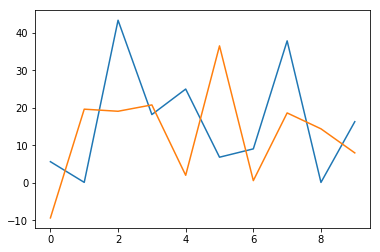

In [124]:
plt.plot(testy[-1])
plt.plot(output_h[-1]) #Plotting for 10 random samples